<a href="https://colab.research.google.com/github/ayaamr11/DisasterTweets-NLP/blob/main/DisasterTweets_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [ ]:
import tensorflow.keras as keras
keras.__version__

'2.8.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models
from tensorflow.keras import layers  
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Get data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayaamr1223","key":"515ab0c79ffa1328032f68aaf9ec4842"}'}

In [ ]:
#Make directory named kaggle
! mkdir ~/.kaggle

In [ ]:
#Copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/

In [ ]:
#Change the permissions of the file. 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [ ]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 93.8MB/s]


In [ ]:
#unzip folder from drive
!unzip "/content/nlp-getting-started.zip"

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Explore data

In [ ]:
#read csv to dataframe
train_df = pd.read_csv('train.csv')
test_df=  pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
#check null values
train_df[['keyword','location','text','target']].isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
#check duplicates
train_df[['keyword','location','text','target']].duplicated().sum()

52

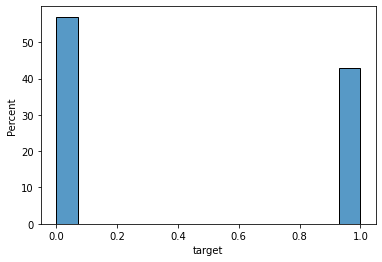

In [ ]:
#check if target column is balanced
sns.histplot(train_df['target'],stat= 'percent')

In [ ]:
train_df['location'] = train_df['location'].astype(str)

In [ ]:
train_df['location'].value_counts()

nan                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [ ]:
np.unique(train_df['location'])

array(['  ', '  Glasgow ', '  Melbourne, Australia', ...,
       'å¡å¡Midwest \x89Û¢\x89Û¢', 'åÊ(?\x89Û¢`?\x89Û¢å«)??',
       'åø\\_(?)_/åø'], dtype=object)

## Data preprocessing ( for train data )

### Remove duplicates

In [ ]:
train_df.drop_duplicates(subset=['keyword','location','text','target'],inplace=True)

In [ ]:
train_df[['keyword','location','text','target']].duplicated().sum()

0

### Handle null values

In [ ]:
train_df['location'] = train_df['keyword'].fillna('unknown')
train_df['keyword'] = train_df['location'].fillna('unknown')

In [ ]:
train_df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

### Text toxenization

In [ ]:
def tokenize(column):

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]    

In [ ]:
# word splittling
train_df['tokenized_text'] = train_df.apply(lambda d: tokenize(d['text']), axis=1)

In [ ]:
train_df[['tokenized_text']].head()

,tokenized_text
0,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,"[All, residents, asked, to, in, place, are, be..."
3,"[people, receive, wildfires, evacuation, order..."
4,"[Just, got, sent, this, photo, from, Ruby, Ala..."


### Convert to lowercase

In [ ]:
def lowerCase_converter(column):

  col = [x.lower() for x in column]
  return col

In [ ]:
# word lowercasing
train_df['preprocessed_text'] = train_df.apply(lambda d: lowerCase_converter(d['tokenized_text']), axis=1)

In [ ]:
train_df['preprocessed_text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, in, place, are, be...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: preprocessed_text, dtype: object

### Remove stopword

In [ ]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def remove_stopWords(column):
  col = [word for word in column if not word in all_stopwords]
  return col

In [ ]:
# remove stopwords
train_df['preprocessed_text'] = train_df.apply(lambda d: remove_stopWords(d['preprocessed_text']), axis=1)

In [ ]:
train_df['preprocessed_text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, place, notified, officers, ...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: preprocessed_text, dtype: object

### Text lemmetization

In [ ]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

In [ ]:
train_df['preprocessed_text'] = train_df.apply(lambda d: lemmatize_words(d['preprocessed_text']), axis=1)

In [ ]:
train_df['preprocessed_text'].head()

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, place, notified, officer, ev...
3    [people, receive, wildfire, evacuation, order,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: preprocessed_text, dtype: object

In [ ]:
train_df['preprocessed_text'] = train_df.apply(lambda d: lemmatize_verbs(d['preprocessed_text']), axis=1)

In [ ]:
train_df['preprocessed_text'].head()

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, ask, place, notify, officer, evacua...
3    [people, receive, wildfire, evacuation, order,...
4    [get, send, photo, ruby, alaska, smoke, wildfi...
Name: preprocessed_text, dtype: object

## Text preprocessing ( for test data )

In [ ]:
test_df['location'] = test_df['keyword'].fillna('unknown')
test_df['keyword'] = test_df['location'].fillna('unknown')
test_df['tokenized_text'] = test_df.apply(lambda d: tokenize(d['text']), axis=1)
test_df['preprocessed_text'] = test_df.apply(lambda d: lowerCase_converter(d['tokenized_text']), axis=1)
test_df['preprocessed_text'] = test_df.apply(lambda d: remove_stopWords(d['preprocessed_text']), axis=1)
test_df['preprocessed_text'] = test_df.apply(lambda d: lemmatize_words(d['preprocessed_text']), axis=1)
test_df['preprocessed_text'] = test_df.apply(lambda d: lemmatize_verbs(d['preprocessed_text']), axis=1)

In [ ]:
test_df.head()

,id,keyword,location,text,tokenized_text,preprocessed_text
0,0,unknown,unknown,Just happened a terrible car crash,"[Just, happened, a, terrible, car, crash]","[happen, terrible, car, crash]"
1,2,unknown,unknown,"Heard about #earthquake is different cities, s...","[Heard, about, earthquake, is, different, citi...","[hear, earthquake, different, city, stay, safe..."
2,3,unknown,unknown,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, g...","[forest, fire, spot, pond, goose, flee, across..."
3,9,unknown,unknown,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting, Spokane, wildfires]","[apocalypse, light, spokane, wildfire]"
4,11,unknown,unknown,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, in, China, and, Tai...","[typhoon, soudelor, kill, china, taiwan]"


## Data preparing 

In [ ]:
train_df.drop(['tokenized_text'],axis=1,inplace=True)
test_df.drop(['tokenized_text'],axis=1,inplace=True)

In [ ]:
# function to convert list of strings to one string
def merge_to_text(column):
  return ' '.join(column)

In [ ]:
train_df['text'] = train_df.apply(lambda d: merge_to_text(d['preprocessed_text']), axis=1)
test_df['text'] = test_df.apply(lambda d: merge_to_text(d['preprocessed_text']), axis=1)

In [ ]:
train_df['text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident ask place notify officer evacuation s...
3       people receive wildfire evacuation order calif...
4       get send photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    thetawniest control wild fire california even ...
7610                              utc volcano hawaii http
7611    police investigate collide car little portugal...
7612    latest home raze northern california wildfire ...
Name: text, Length: 7561, dtype: object

In [ ]:
train_text= train_df['text'].tolist()
test_text= test_df['text'].tolist()

In [ ]:
y_train = train_df['target']

## Bag Of Words ( BoW )

In [ ]:
tok = Tokenizer(num_words=1000, oov_token='UNK')
tok.fit_on_texts(train_text + test_text)
# Extract binary BoW features
x_train = tok.texts_to_matrix(train_text, mode='binary')
x_test = tok.texts_to_matrix(test_text, mode='binary')

In [ ]:
vocab_size = len(tok.word_index) + 1

In [ ]:
vocab_size

15657

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(7561, 1000)
(7561,)
(3263, 1000)


In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## Normal Dense Model

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
13/13 [==============================] - 1s 18ms/step - loss: 0.6799 - binary_accuracy: 0.6426 - val_loss: 0.6606 - val_binary_accuracy: 0.7580
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 0.6429 - binary_accuracy: 0.7458 - val_loss: 0.6216 - val_binary_accuracy: 0.7830
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.5957 - binary_accuracy: 0.7884 - val_loss: 0.5779 - val_binary_accuracy: 0.7980
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.5447 - binary_accuracy: 0.8029 - val_loss: 0.5388 - val_binary_accuracy: 0.7970
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 0.4985 - binary_accuracy: 0.8099 - val_loss: 0.5090 - val_binary_accuracy: 0.7870
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 0.4604 - binary_accuracy: 0.8180 - val_loss: 0.5023 - val_binary_accuracy: 0.7750
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.4

In [ ]:
test_loss, test_acc = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 2ms/step - loss: 0.5576 - binary_accuracy: 0.7670


In [ ]:
test_acc

0.7269999980926514

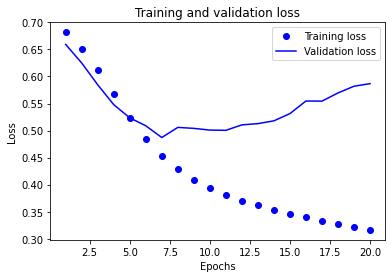

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Data Padding

In [ ]:
max_len = max([len(t) for t in train_text])
all_len=[len(t) for t in train_text]

In [ ]:
max_len

137

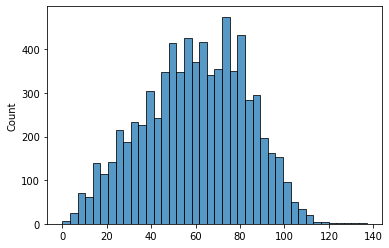

In [ ]:
sns.histplot(all_len)

In [ ]:
#let max length of padding 110
max_len=110

In [ ]:
train_message= tok.texts_to_sequences(train_text)

train_padded = pad_sequences(train_message,
                                maxlen=max_len, 
                                truncating='post', 
                                padding='post'
                               )

In [ ]:
test_message = tok.texts_to_sequences(test_text)

test_padded = pad_sequences(test_message,
                                maxlen=max_len, 
                                truncating='post', 
                                padding='post'
                               )

In [ ]:
print(train_padded.shape)
print(test_padded.shape)

(7561, 110)
(3263, 110)


In [ ]:
training_padded = np.array(train_padded)
x_val = training_padded[:1000]
partial_x_train = training_padded[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## LSTM Model

In [ ]:
lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(vocab_size, 64, input_length=max_len))
lstm_model.add(layers.LSTM(50))
lstm_model.add(layers.Flatten())
lstm_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 110, 64)           1002048   
                                                                 
 lstm_7 (LSTM)               (None, 50)                23000     
                                                                 
 flatten_8 (Flatten)         (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,025,099
Trainable params: 1,025,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[metrics.binary_accuracy]
)

In [ ]:
history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/10
26/26 [==============================] - 34s 294ms/step - loss: 0.6887 - binary_accuracy: 0.5475 - val_loss: 0.6582 - val_binary_accuracy: 0.6960
Epoch 2/10
26/26 [==============================] - 6s 230ms/step - loss: 0.6878 - binary_accuracy: 0.5527 - val_loss: 0.6567 - val_binary_accuracy: 0.6960
Epoch 3/10
26/26 [==============================] - 6s 229ms/step - loss: 0.6879 - binary_accuracy: 0.5527 - val_loss: 0.6579 - val_binary_accuracy: 0.6960
Epoch 4/10
26/26 [==============================] - 6s 226ms/step - loss: 0.6878 - binary_accuracy: 0.5527 - val_loss: 0.6573 - val_binary_accuracy: 0.6960
Epoch 5/10
26/26 [==============================] - 6s 228ms/step - loss: 0.6878 - binary_accuracy: 0.5527 - val_loss: 0.6595 - val_binary_accuracy: 0.6960
Epoch 6/10
26/26 [==============================] - 6s 232ms/step - loss: 0.6879 - binary_accuracy: 0.5527 - val_loss: 0.6567 - val_binary_accuracy: 0.6960
Epoch 7/10
26/26 [==============================] - 7s 258ms/st

In [ ]:
test_loss, test_acc = lstm_model.evaluate(x_val, y_val)

32/32 [==============================] - 1s 15ms/step - loss: 0.6566 - binary_accuracy: 0.6960


## Bidirectional LSTM

In [ ]:
blstm_model = models.Sequential()
blstm_model.add(layers.Embedding(vocab_size, 128, input_length=max_len))
blstm_model.add(layers.Bidirectional(layers.LSTM(50, dropout=0.2)))
blstm_model.add(layers.Flatten())
blstm_model.add(layers.Dense(1, activation='sigmoid'))

blstm_model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[metrics.binary_accuracy]
)


In [ ]:
blstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 110, 128)          2004096   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              71600     
 nal)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,075,797
Trainable params: 2,075,797
Non-trainable params: 0
_________________________________________________________________


In [ ]:
blstm_model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[metrics.binary_accuracy]
)

In [ ]:
history = blstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/10
26/26 [==============================] - 20s 763ms/step - loss: 0.3770 - binary_accuracy: 0.8346 - val_loss: 0.4796 - val_binary_accuracy: 0.7920
Epoch 2/10
26/26 [==============================] - 16s 622ms/step - loss: 0.3715 - binary_accuracy: 0.8400 - val_loss: 0.4757 - val_binary_accuracy: 0.7970
Epoch 3/10
26/26 [==============================] - 16s 625ms/step - loss: 0.3712 - binary_accuracy: 0.8377 - val_loss: 0.4971 - val_binary_accuracy: 0.7850
Epoch 4/10
26/26 [==============================] - 16s 627ms/step - loss: 0.3697 - binary_accuracy: 0.8390 - val_loss: 0.4870 - val_binary_accuracy: 0.7930
Epoch 5/10
26/26 [==============================] - 22s 839ms/step - loss: 0.3673 - binary_accuracy: 0.8387 - val_loss: 0.4905 - val_binary_accuracy: 0.7880
Epoch 6/10
26/26 [==============================] - 17s 658ms/step - loss: 0.3631 - binary_accuracy: 0.8430 - val_loss: 0.4920 - val_binary_accuracy: 0.7870
Epoch 7/10
26/26 [==============================] - 16s 62

In [ ]:
test_loss, test_acc = blstm_model.evaluate(x_val, y_val)

32/32 [==============================] - 1s 29ms/step - loss: 0.4991 - binary_accuracy: 0.7930


## GRU Model

In [ ]:
GRU_model = models.Sequential()
GRU_model.add(layers.Embedding(vocab_size, 64))
GRU_model.add(layers.Bidirectional(layers.GRU(64)))
GRU_model.add(layers.Dense(1, activation='sigmoid'))

GRU_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 64)          1002048   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              49920     
 nal)                                                            
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,052,097
Trainable params: 1,052,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = GRU_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/10
26/26 [==============================] - 18s 521ms/step - loss: 0.6841 - binary_accuracy: 0.5528 - val_loss: 0.6475 - val_binary_accuracy: 0.6960
Epoch 2/10
26/26 [==============================] - 13s 487ms/step - loss: 0.6622 - binary_accuracy: 0.5822 - val_loss: 0.6021 - val_binary_accuracy: 0.7330
Epoch 3/10
26/26 [==============================] - 13s 491ms/step - loss: 0.6020 - binary_accuracy: 0.7107 - val_loss: 0.5445 - val_binary_accuracy: 0.7590
Epoch 4/10
26/26 [==============================] - 13s 488ms/step - loss: 0.5226 - binary_accuracy: 0.7654 - val_loss: 0.4934 - val_binary_accuracy: 0.7740
Epoch 5/10
26/26 [==============================] - 13s 490ms/step - loss: 0.4652 - binary_accuracy: 0.7868 - val_loss: 0.4759 - val_binary_accuracy: 0.7830
Epoch 6/10
26/26 [==============================] - 13s 488ms/step - loss: 0.4344 - binary_accuracy: 0.8019 - val_loss: 0.4809 - val_binary_accuracy: 0.7920
Epoch 7/10
26/26 [==============================] - 13s 48

In [ ]:
test_loss, test_acc = GRU_model.evaluate(x_val, y_val)

32/32 [==============================] - 1s 23ms/step - loss: 0.4694 - binary_accuracy: 0.8020


In [ ]:
test_acc

0.8019999861717224